In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Quality control of cells

In [7]:
params = []

# HG001
d = pd.read_csv("../../1_NanoStrandSeq/reports/NanoStrandSeq_Summary.csv")
d = d[(d["Strain"] == "HG001") & (d["Remark"] != "Control")]
params.append(["NanoStrand-seq", 80000, 0.05, d])

# C57/DBA
d = pd.read_csv("../../1_NanoStrandSeq/reports/NanoStrandSeq_Summary.csv")
d = d[d["Strain"] == "B6D2F1"]
params.append(["NanoStrand-seq.MM", 70000, 0.05, d])

# Strand-seq
d = pd.read_csv("../../2_StrandSeq/reports/StrandSeq_Summary.csv")
d = d[d["Run"] == "20160928_PRJEB14185_CEU"]
params.append(["Strand-seq", 800000, 0.05, d])

# OP-Strand-seq
d = pd.read_csv("../../2_StrandSeq/reports/StrandSeq_Summary.csv")
d = d[d["Run"] == "20210729_PRJNA742746_HG001"]
params.append(["OP-Strand-seq", 2000000, 0.05, d])

Total	Pass	Name
826	364	NanoStrand-seq
455	206	NanoStrand-seq.MM
132	94	Strand-seq
656	74	OP-Strand-seq


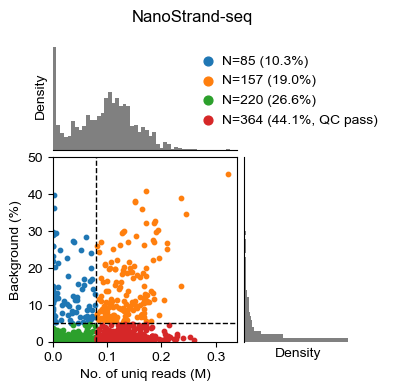

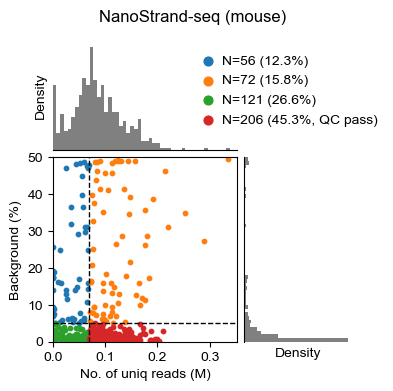

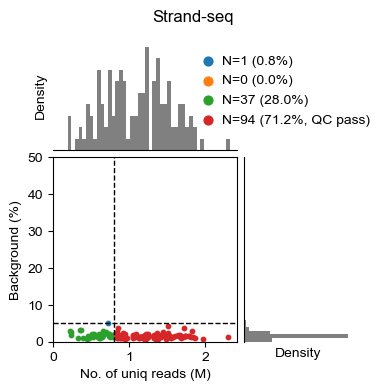

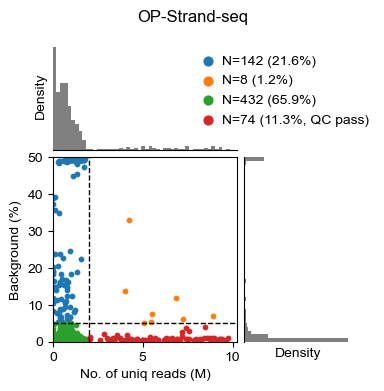

In [8]:
print("Total\tPass\tName")
for name, min_reads, max_bg, df in params:   
    df = df.copy()
    df["Background"] = np.nan_to_num(df["Background"], 0)
    array = [
        [df[(df["UniqReads"] < min_reads) & (df["Background"] >= max_bg)], "C0"],
        [df[(df["UniqReads"] >= min_reads) & (df["Background"] >= max_bg)], "C1"],
        [df[(df["UniqReads"] < min_reads) & (df["Background"] < max_bg)], "C2"],
        [df[(df["UniqReads"] >= min_reads) & (df["Background"] < max_bg)], "C3"]
    ]
    
    fig = plt.figure(figsize=(4, 4))
    gs = fig.add_gridspec(2, 2, width_ratios=(1.7, 1), height_ratios=(1, 1.7),
                          left=0.15, right=0.9, bottom=0.15, top=0.9,
                          wspace=0.05, hspace=0.05)
    ax = fig.add_subplot(gs[1, 0])
    ax_histx = fig.add_subplot(gs[0, 0])
    ax_histy = fig.add_subplot(gs[1, 1])
    ax_histx.set_facecolor("none")
    if name == "NanoStrand-seq.MM":
        plt.suptitle("NanoStrand-seq (mouse)")
    else:
        plt.suptitle(name)
    if True:
        plt.sca(ax)
        for i, (df1, color) in enumerate(array):
            xs = df1["UniqReads"] / 1000000
            ys = df1["Background"] * 100
            label = "N=%d (%.1f%%)" % (len(df1), len(df1)*100/len(df))
            if i == 3:
                label = "N=%d (%.1f%%, QC pass)" % (len(df1), len(df1)*100/len(df))
            plt.scatter(xs, ys, color=color, marker="o", s=10, 
                        label=label)
        plt.axvline(min_reads / 1e6, color="black", lw=1, ls="--")
        plt.axhline(max_bg * 100, color="black", lw=1, ls="--")
        xmax = max(df["UniqReads"]) / 1e6 * 1.05
        plt.xlim(0, xmax)
        plt.ylim(0, 50)
        plt.xlabel("No. of uniq reads (M)")
        plt.ylabel("Background (%)")
        plt.legend(loc="lower left", bbox_to_anchor=(0.7, 1.1), 
                   markerscale=2, handletextpad=0, frameon=False)
    if True:
        plt.sca(ax_histx)
        plt.hist(df["UniqReads"]/1e6, range=(0, xmax), bins=50, color="grey")
        plt.xlim(0, xmax)
        ax_histx.spines["top"].set_visible(False)
        ax_histx.spines["left"].set_visible(False)
        ax_histx.spines["right"].set_visible(False)
        plt.ylabel("Density")
        plt.xticks([])
        plt.yticks([])
    if True:
        plt.sca(ax_histy)
        plt.hist(df["Background"] * 100, range=(0, 50), bins=50, color="grey",
                 orientation="horizontal")
        plt.ylim(0, 50)
        ax_histy.spines["top"].set_visible(False)
        ax_histy.spines["bottom"].set_visible(False)
        ax_histy.spines["right"].set_visible(False)
        plt.xlabel("Density")
        plt.yticks([])
        plt.xticks([])
    plt.savefig("figures/cell_qc.%s.pdf" % name, dpi=300)

    df.to_csv("results/%s.csv" % name, index=False)
    array[3][0].to_csv("results/%s.qc_pass.csv" % name, index=False)
    print(len(df), len(df1), name, sep="\t")